<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-Problem" data-toc-modified-id="The-Problem-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The Problem</a></span><ul class="toc-item"><li><span><a href="#Some-Examples" data-toc-modified-id="Some-Examples-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Some Examples</a></span><ul class="toc-item"><li><span><a href="#Stationary-Example" data-toc-modified-id="Stationary-Example-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Stationary Example</a></span></li><li><span><a href="#Non-Stationary-Example" data-toc-modified-id="Non-Stationary-Example-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Non-Stationary Example</a></span></li><li><span><a href="#Seasonal-Example" data-toc-modified-id="Seasonal-Example-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Seasonal Example</a></span></li></ul></li></ul></li></ul></div>

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import xarray as xr
from scipy import stats

config = {'figure.figsize':(12, 4),
          'figure.dpi':72.0 * 2,
          'figure.facecolor':'w',
          'axes.grid':True,
          'grid.linewidth':0.5,
          'grid.linestyle':'--',
          'axes.spines.top':False,
          'axes.spines.bottom':False,
          'axes.spines.left':False,
          'axes.spines.right':False,
          'figure.constrained_layout.use':True}

plt.rcParams.update(config)

# The Problem

When we model time series, we want them to be **stationary**. This is a requirement that arises from the types of statistical models we use on time series data. For a technical explaination, see [these](https://www.youtube.com/watch?v=-gmlyRRscXo&list=PLwJRxp3blEvZyQBTTOMFRP_TDaSdly3gU&index=160) [videos](https://www.youtube.com/watch?v=bWo_ka37szw&list=PLwJRxp3blEvZyQBTTOMFRP_TDaSdly3gU&index=161) [by](https://www.youtube.com/watch?v=LgIOgb-6mYA&list=PLwJRxp3blEvZyQBTTOMFRP_TDaSdly3gU&index=162) [Ben](https://www.youtube.com/watch?v=a7_3qX67e7c&list=PLwJRxp3blEvZyQBTTOMFRP_TDaSdly3gU&index=163) [Lambert](https://www.youtube.com/watch?v=wL8NgC0Fm0Y&list=PLwJRxp3blEvZyQBTTOMFRP_TDaSdly3gU&index=164) [about](https://www.youtube.com/watch?v=BGNjzEIqi6M&list=PLwJRxp3blEvZyQBTTOMFRP_TDaSdly3gU&index=165) [the](https://www.youtube.com/watch?v=JytDF8ph2ko&list=PLwJRxp3blEvZyQBTTOMFRP_TDaSdly3gU&index=166) Gauss-Markov assumptions, applied to time series.

Actually, we aren't going to be using OLS to estimate our models in this class, but the videos are still good for building intuition. Basically, in the "normal" cross-sectional setup, we're exploting observed va in a **population** to learn something about that population. That makes sense when we're studying something that maps to a notion of a population, like penguins or cities. But what is the population of GDP figures? Clearly this is nonsense, because we only observe one GDP. Therefore we need a different framework to think about data like GDP. 

Instead of assuming that these data come from a population, we assume they come from a **process**. A process is a single, static function that **generates** realizations of the data we observe. This assumption gives us some variation we can exploit in a unique object, like GDP, to make some statistical inference about it.

## Some Examples

Perhaps it's better to see what this means by looking at some examples. Let's generate some data from a stationary process.

In [243]:
def generate_time_series(x0, T, Z, R, Q, n_simulations=100, simulation_length=100, H = None, seed=None):
    n_states = x0.shape[0]
    n_obs = Z.shape[0]
    rng = np.random.default_rng(seed)
    
    shocks = rng.multivariate_normal(mean=np.zeros(n_states), cov=R @ Q @ R.T, size=(n_simulations, simulation_length))
    observation_noise = np.zeros((n_simulations, simulation_length, n_obs))
    if H is not None:
        observation_noise = rng.multivariate_normal(mean=np.zeros(n_obs), cov=H, size=(n_simulations, simulation_length))
    
    data = np.zeros((n_simulations, simulation_length, n_states))
    observed = np.zeros((n_simulations, simulation_length, n_obs))
    
    data[:, 0, :] = x0
    observed[:, 0, :] = Z @ x0
    vec_matmul = np.vectorize(lambda A, b: A @ b, signature='(n,m),(m)->(n)')
    for t in range(1, simulation_length):
        data[:, t, :] = vec_matmul(T, data[:, t-1, :]) + shocks[:, t]
        observed[:, t, :] = vec_matmul(Z, data[:, t, :]) + observation_noise[:, t]
    
    return data, observed

def plot_simulation_and_cross_section(data, t, bins=25):
    fig = plt.figure()
    gs = plt.GridSpec(1,4, figure=fig)
    
    ax_line = fig.add_subplot(gs[0, :3])
    ax_hist = fig.add_subplot(gs[0, -1])
    
    x_grid = np.arange(data.shape[1])
    ax_line.plot(x_grid, data.squeeze().T);
    
    t_values = [t] if not isinstance(t, list) else t
    for t in t_values:
        ax_line.axvline(t, c='k')
        t_slice = data[:, t, 0]

        ax_line.scatter(np.full_like(t_slice, t), t_slice, zorder=100, facecolor='k', alpha=0.25)
        ax_hist.hist(t_slice, bins=bins, orientation='horizontal', alpha=0.5)
    ax_hist.set(ylim=ax_line.get_ylim(), yticklabels=[], xticklabels=[])
    plt.show()
    
def timeseries_ridgeplot(data, plot_start=1, plot_every=10, pdf_scale=10):
    fig, ax = plt.subplots()
    T = data.shape[1]
    for t in range(plot_start, T, plot_every):
        t_slice = data[:, t, 0]
        kde = stats.gaussian_kde(t_slice)
        y_grid = np.linspace(t_slice.min(), t_slice.max(), 100)
        x_values = t + pdf_scale * kde.pdf(y_grid)
    
        ax.plot(x_values, y_grid, color='k')
        ax.fill_betweenx(y_grid, t, x_values, color='tab:blue', alpha=0.25)
        ax.scatter(t, t_slice.mean(), c='k', zorder=100)
    x_grid = np.arange(T)
    mu = data.mean(axis=0).squeeze()
    ax.plot(x_grid, mu, ls='--', color='k', lw=2)
    plt.show()

### Stationary Example

This first example is the one we can do something with. It's safe to assume our data comes from a single generating function that doesn't change over time. Notice how everything is bounded from above and below, and the trajectories just make a nice fuzzy catterpillar. All of the marginal distributions (plotted as histograms on the right) are identical.

In [261]:
x0 = np.zeros(2)
T = np.array([[0.95, -0.1],
              [1.0,   0.0]])
assert np.all(np.abs(np.linalg.eigvals(T)) < 1)
R = np.array([[1.0],
              [0.0]])
Q = np.array([[1.0]])
Z = np.array([[1.0, 0.0]])

states, data = generate_time_series(x0, T, Z, R, Q, n_simulations=1000)

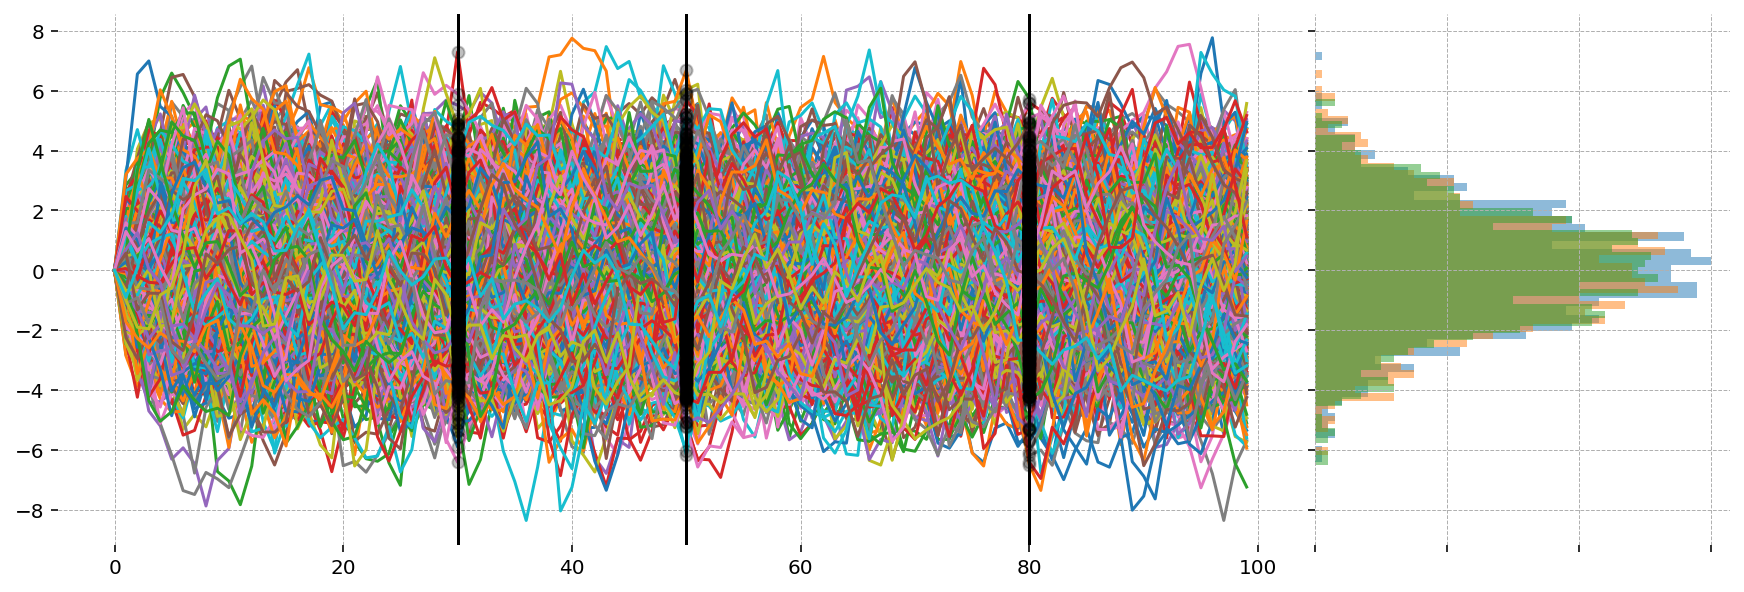

In [262]:
plot_simulation_and_cross_section(data, t=[30, 50, 80], bins=50)

We can emphasize that the marginal distributions are stable across time by making a ridge plot. Every 5 timesteps we draw the marginal KDE. Notice how they are totally identica, and the mean (black dashed line) is flat.

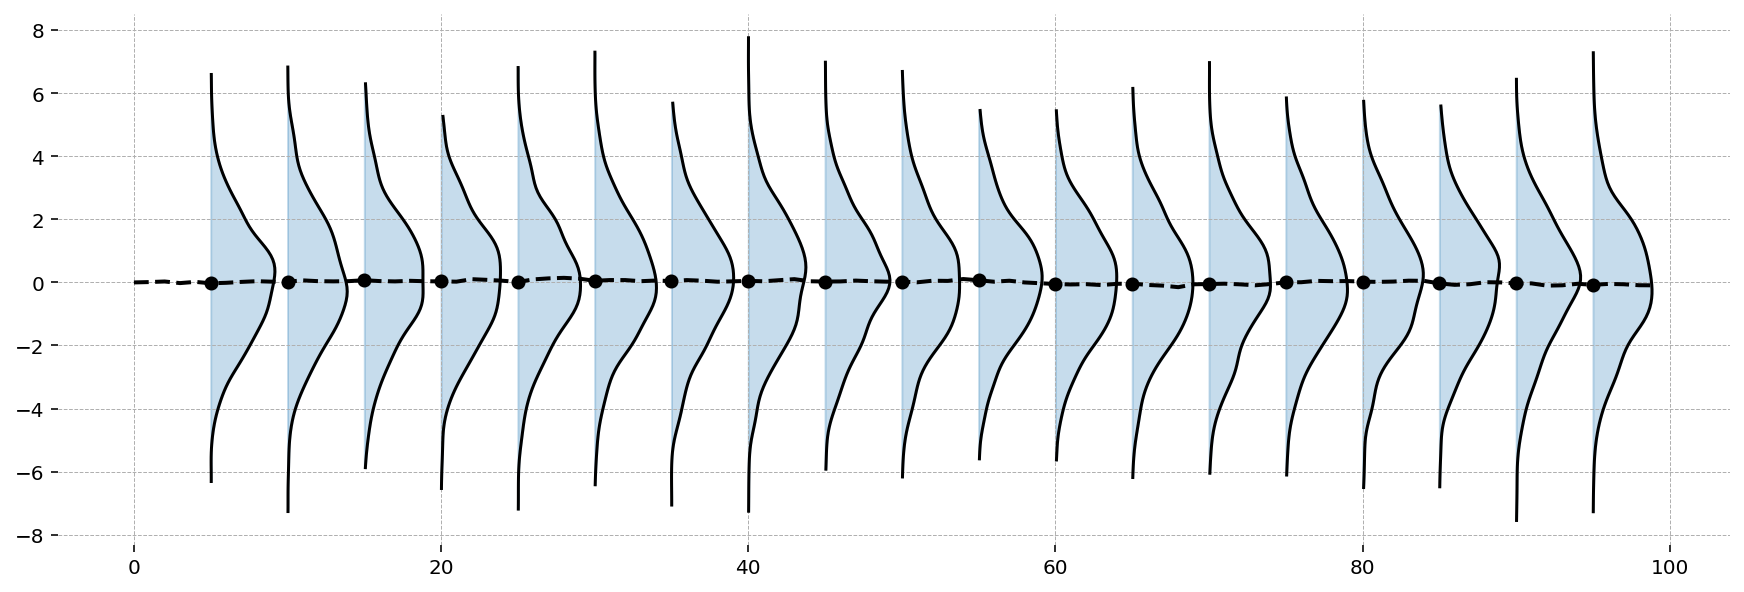

In [264]:
timeseries_ridgeplot(data, plot_start=5, pdf_scale=20, plot_every=5)

### Non-Stationary Example

Non-stationary data will have 1) a mean that changes over time, or 2) covariance that changes over time. For the next example I generate data from a model that has both of these features.

In [265]:
x0 = np.ones(2)
T = np.array([[1.0, 1.0],
              [0.0, 1.0]])
R = np.array([[1.0, 0.0],
              [0.0, 1.0]])
Q = np.array([[1.0, 0.0],
              [0.0, 0.001]])
Z = np.array([[1.0, 0.0]])

states, data = generate_time_series(x0, T, Z, R, Q, n_simulations=1000)

Notice how there is a positive trend -- all trajectories increase deterministically. Each trajectory also wiggles around. Within the marginal slices, the mean and the variance are increasing. 

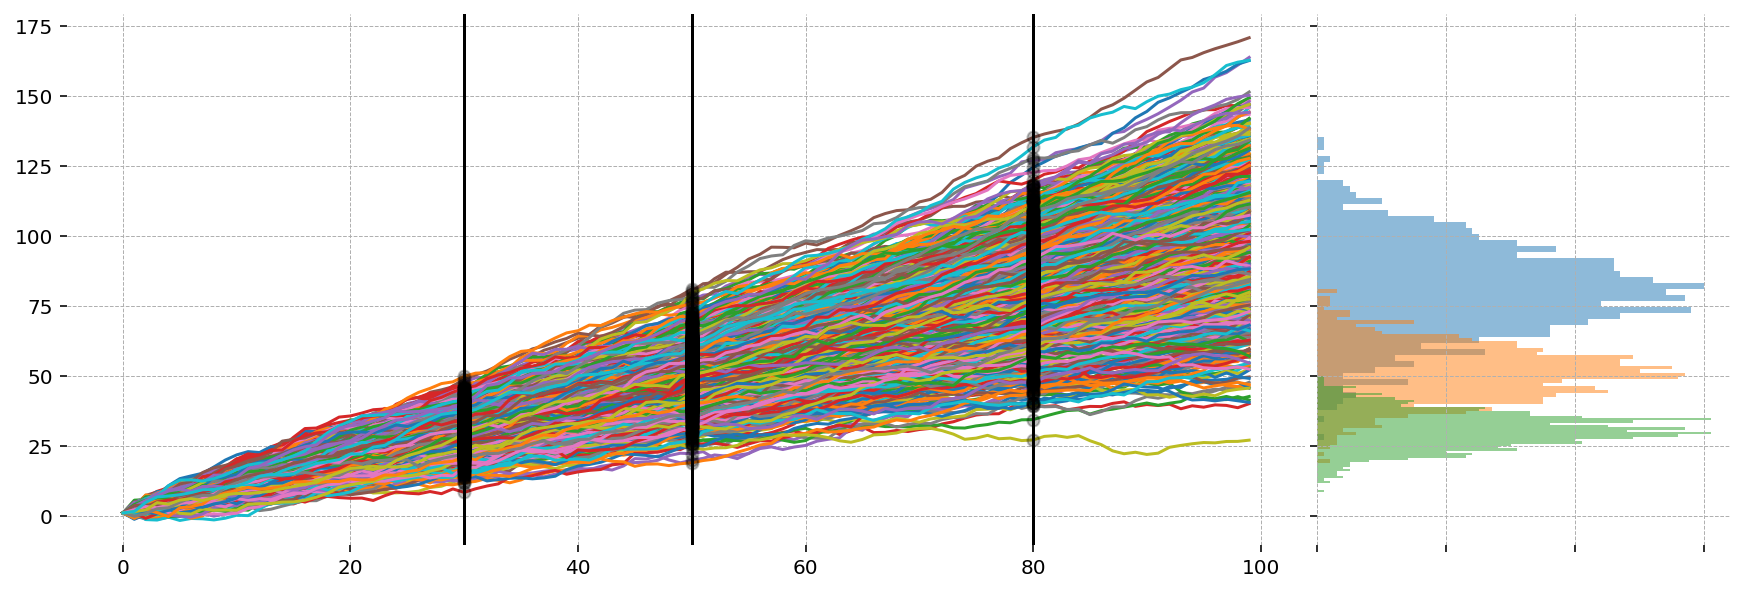

In [266]:
plot_simulation_and_cross_section(data, t=[80, 50, 30], bins=50)

The increasing marginal variance is even more obvious in the ridge plot.

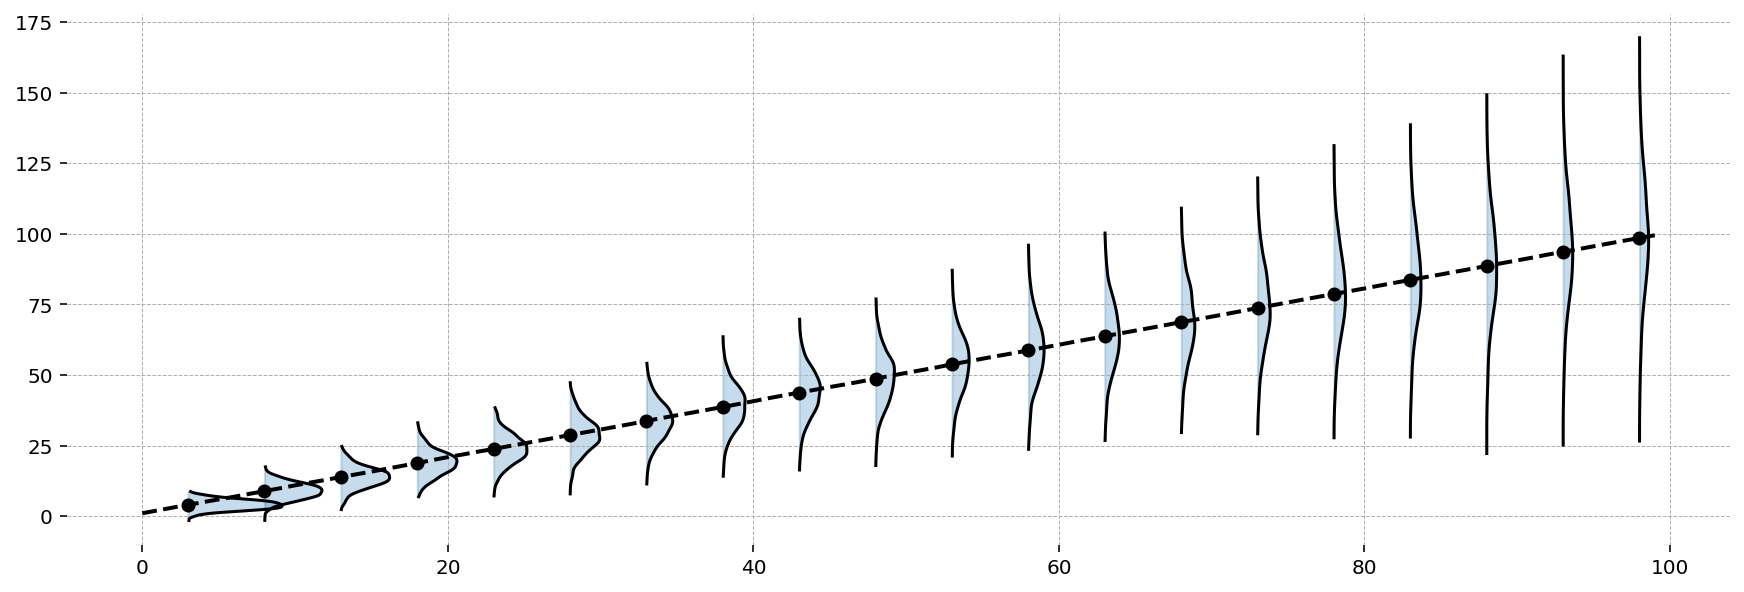

In [267]:
timeseries_ridgeplot(data, pdf_scale=30, plot_start=3, plot_every=5)

### Seasonal Example

Seasonality is also non-stationary, because the covariance between timesteps is not constant. 

In [258]:
x0 = np.random.normal(scale=0.1, size=11)
x0 = np.r_[x0.sum(), x0].squeeze()

T = np.eye(12, k=-1)
T[0] = -1
R = np.zeros((12, 1))
R[0] = 1
Q = np.eye(1) * 0
Z = np.zeros((1, 12))
Z[0] = 1
H = np.eye(1) * 0.005

states, data = generate_time_series(x0, T, Z, R, Q, H=H, n_simulations=1000)

Notice that the mean of the marginal distribution depends on when we sample the population of trajectories.

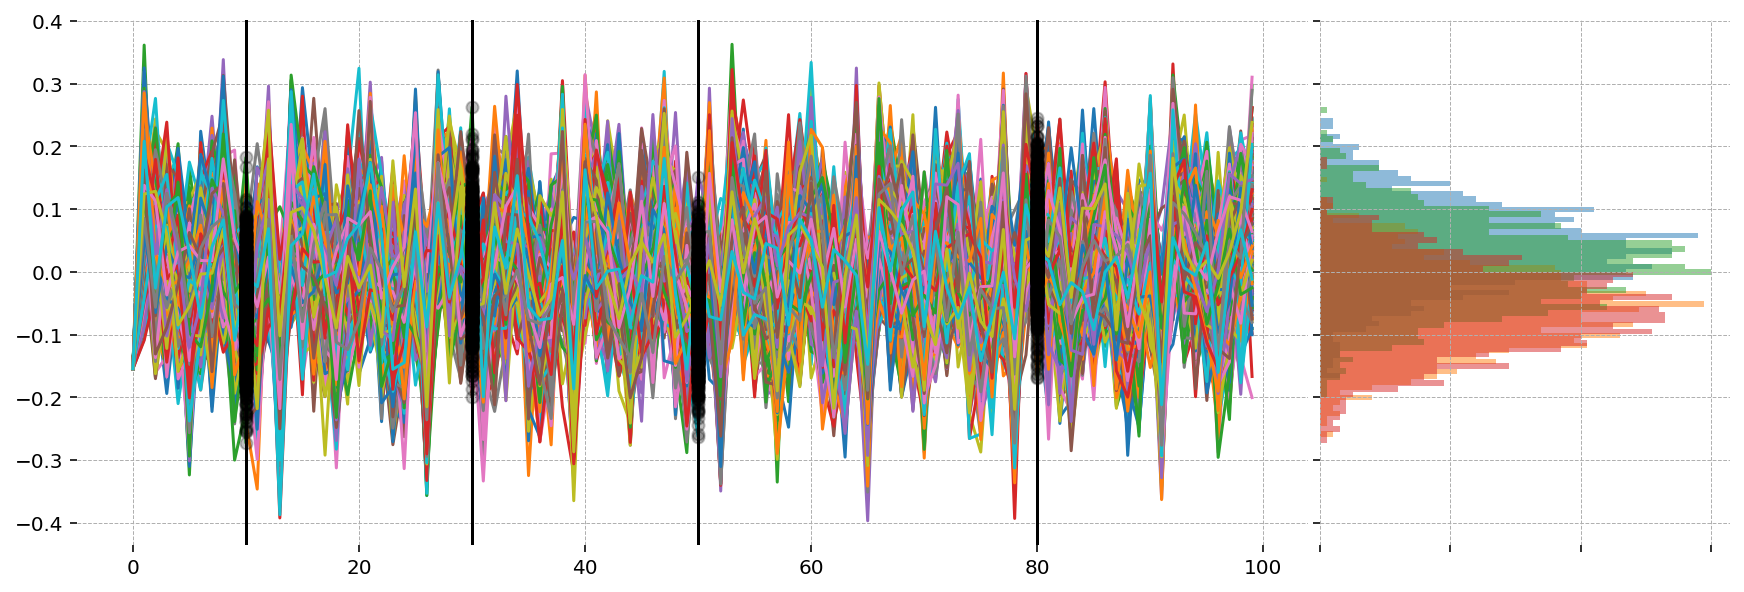

In [259]:
plot_simulation_and_cross_section(data, t=[80, 50, 30, 10], bins=50)

Looking at the ridge plot, we see that the marginals bounce around. Unlike the first non-stationary example, though, the variance is stable. 

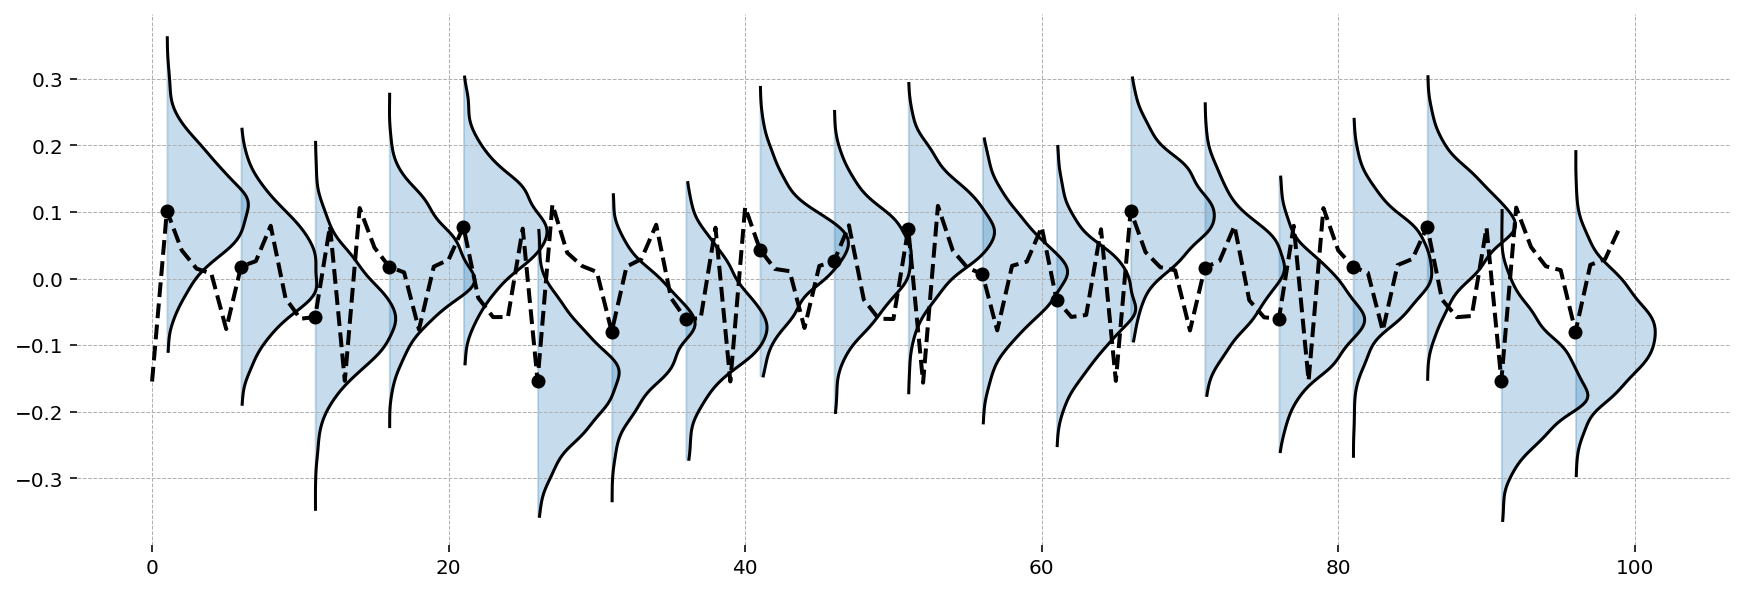

In [260]:
timeseries_ridgeplot(data, pdf_scale=1, plot_start=1, plot_every=5)